In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploring Dataset

**Import Necessary Libraries**

In [2]:
import warnings 
warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import cv2

import numpy as np
import tensorflow.keras.layers as tfl
import seaborn as sns
from sklearn.utils import shuffle 
from tqdm import tqdm
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten,Activation,Dense,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

**Reading the Dataset**

In [3]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_paths = []
train_labels = []

test_paths = []
test_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+"//" +label):
        train_paths.append(train_dir + '//'+label+ '//'+image)
        train_labels.append(label)

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+"//" +label):
        test_paths.append(test_dir + '//'+label+ '//'+image)
        test_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

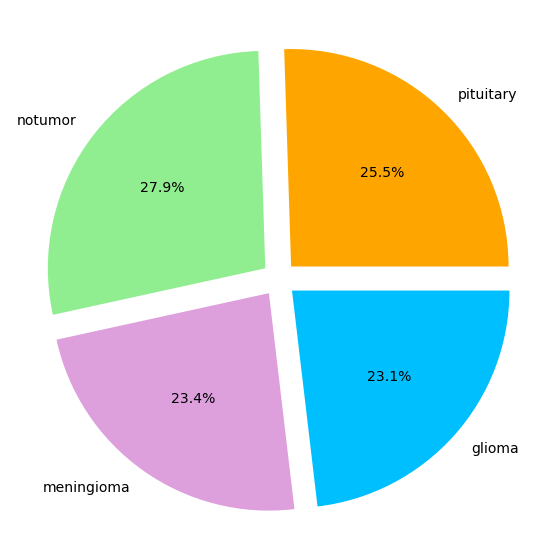

In [47]:
plt.figure(figsize=(10,10))
colors = ['Orange', 'lightgreen', 'plum', 'deepskyblue']
plt.pie([len(os.listdir(train_dir+"//" +label)) 
        for label in os.listdir(train_dir)],
         labels=os.listdir(train_dir),
          colors = colors,
           explode = (0.08,0.08,0.08,0.08) 
           ,autopct='%1.1f%%')
plt.show()

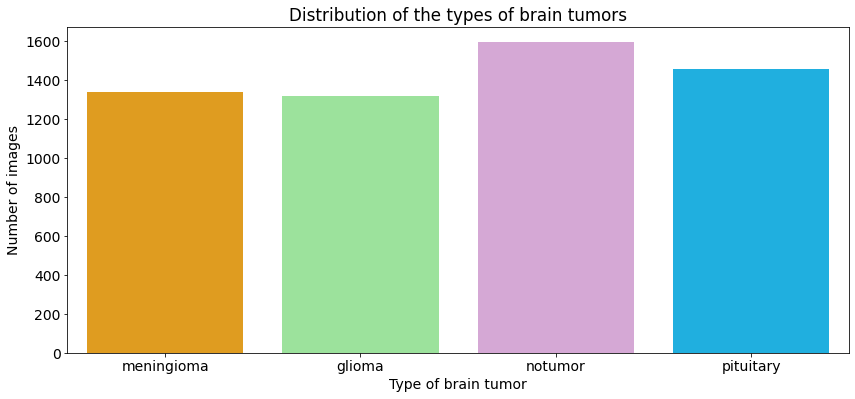

In [48]:
plt.figure(figsize=(14,6))
sns.countplot(train_labels, palette=colors)
plt.title('Distribution of the types of brain tumors')
plt.xlabel('Type of brain tumor')
plt.ylabel('Number of images');

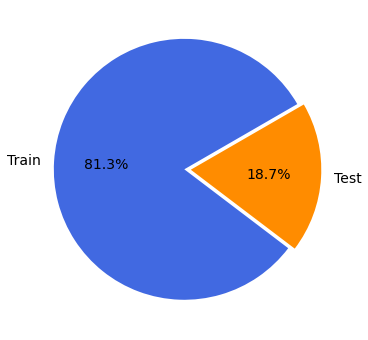

In [51]:
plt.figure(figsize=(14,6))
colors = ['royalblue' , 'darkorange']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

In [7]:
#imgGen = ImageDataGenerator(rescale = 1/255)
#brainTumor=imgGen.flow_from_directory('/kaggle/input/brain-tumor-mri-dataset/Training')
#brainTumor.class_indices

In [8]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv.imread(os.path.join(folderPath, j))
        image = cv.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
  # Join two or more pathname components
    folderPath = os.path.join('/kaggle/input/brain-tumor-mri-dataset/','Testing',i) 
    for j in tqdm(os.listdir(folderPath)):
        image = cv.imread(os.path.join(folderPath, j))
        image = cv.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 300/300 [00:03<00:00, 99.02it/s] 


In [9]:
X_train.shape 

(7023, 150, 150, 3)

**#Vizualise some shuffled data in a grid form**

Before Shuffling 

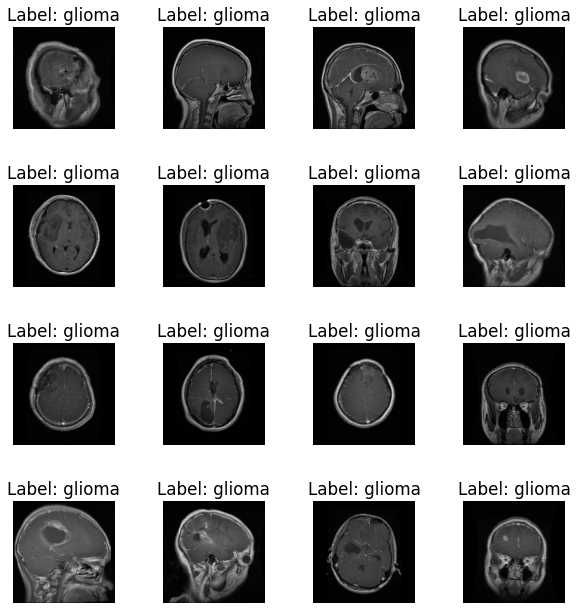

In [10]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

After Shuffling

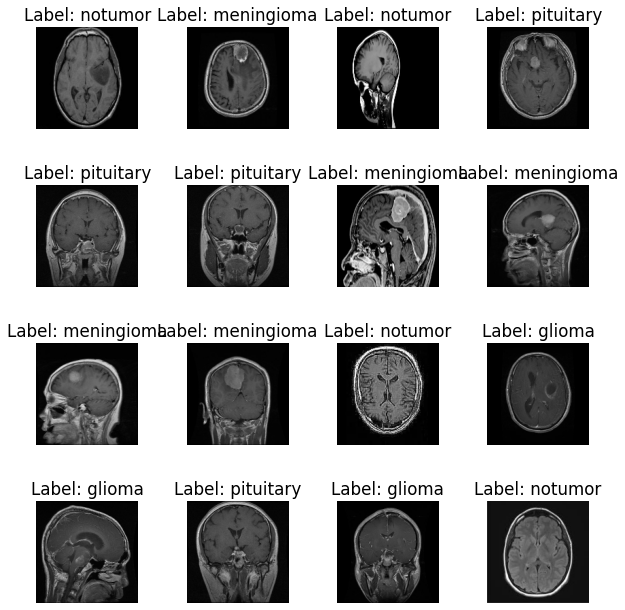

In [11]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55) 

# Splitting Data
Training 70%
Testing 20%
Valid 10%


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Labels:From Categorical to String

In [13]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

**Scaling Data**

In [14]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# **Basic CNN Model**

* **First Model**

In [15]:
model1 =Sequential()

#convolution and maxpoollayer
model1.add(Conv2D(filters=10,kernel_size=3,input_shape=(150,150,3)))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size=2))

#flatten layer
model1.add(Flatten())

#hidden layer
model1.add(Dense(16))
model1.add(Activation('relu'))

#output layer
model1.add(Dense(4))
model1.add(Activation('sigmoid'))
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

2022-12-08 11:51:49.498508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 11:51:49.499493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 11:51:49.760806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 11:51:49.761682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 11:51:49.762466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [16]:
plot_model(model1, show_shapes=True)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 10)      280       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 10)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 54760)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                876176    
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6

In [17]:
history = model1.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=9,
                   verbose=1)

2022-12-08 11:51:56.858164: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1365120000 exceeds 10% of free system memory.
2022-12-08 11:51:58.394226: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1365120000 exceeds 10% of free system memory.
2022-12-08 11:51:59.527168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/9


2022-12-08 11:52:02.053627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


158/158 [==============================] - 16s 15ms/step - loss: 0.6699 - accuracy: 0.7385 - val_loss: 0.4398 - val_accuracy: 0.8505
Epoch 2/9
158/158 [==============================] - 2s 12ms/step - loss: 0.3347 - accuracy: 0.8786 - val_loss: 0.4608 - val_accuracy: 0.8078
Epoch 3/9
158/158 [==============================] - 2s 12ms/step - loss: 0.2043 - accuracy: 0.9310 - val_loss: 0.2918 - val_accuracy: 0.9075
Epoch 4/9
158/158 [==============================] - 2s 12ms/step - loss: 0.1165 - accuracy: 0.9676 - val_loss: 0.2713 - val_accuracy: 0.9164
Epoch 5/9
158/158 [==============================] - 2s 12ms/step - loss: 0.0686 - accuracy: 0.9852 - val_loss: 0.2592 - val_accuracy: 0.9270
Epoch 6/9
158/158 [==============================] - 2s 13ms/step - loss: 0.0431 - accuracy: 0.9921 - val_loss: 0.2963 - val_accuracy: 0.9093
Epoch 7/9
158/158 [==============================] - 2s 15ms/step - loss: 0.0245 - accuracy: 0.9968 - val_loss: 0.2671 - val_accuracy: 0.9270
Epoch 8/9
158/1

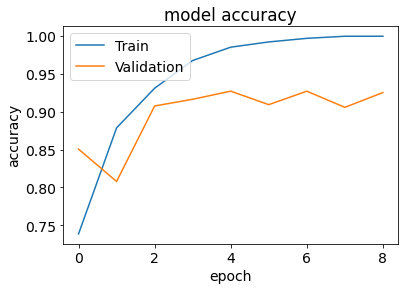

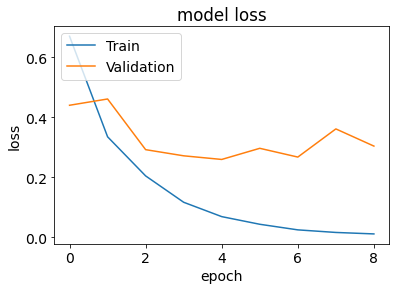

In [18]:
import matplotlib.pyplot as plt

# summarize history for accuracy
history=model1.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

* **Second Model**

In [52]:
from keras.layers import BatchNormalization
model2 =Sequential()
#4convolution layers and 2 maxpoollayer
model2.add(Conv2D(filters=32,kernel_size=4,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32,kernel_size=4,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPool2D(pool_size=3))
model2.add(Dropout(0.2))

model2.add(Conv2D(filters=25,kernel_size=4,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=25,kernel_size=4,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=3))
model2.add(Dropout(0.3))

model2.add(Conv2D(filters=25,kernel_size=3,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=25,kernel_size=3,input_shape=(150,150,3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPool2D(pool_size=3))
model2.add(Dropout(0.4))
#flatten layer
model2.add(Flatten())
#Deeeper hidden layer
model2.add(Dense(100))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Activation('relu'))
#output layer
model2.add(Dense(4))
model2.add(Activation('softmax'))
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [54]:
plot_model(model2, show_shapes=True)
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 147, 147, 32)      1568      
_________________________________________________________________
activation_19 (Activation)   (None, 147, 147, 32)      0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 147, 147, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 144, 144, 32)      16416     
_________________________________________________________________
activation_20 (Activation)   (None, 144, 144, 32)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 144, 144, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 32)       

In [64]:
history = model2.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=9,
                   verbose=1)

Epoch 1/9
158/158 [==============================] - 8s 48ms/step - loss: 0.1109 - accuracy: 0.9614 - val_loss: 0.5023 - val_accuracy: 0.8541
Epoch 2/9
158/158 [==============================] - 7s 46ms/step - loss: 0.1104 - accuracy: 0.9626 - val_loss: 0.3002 - val_accuracy: 0.9110
Epoch 3/9
158/158 [==============================] - 7s 46ms/step - loss: 0.0913 - accuracy: 0.9689 - val_loss: 0.1224 - val_accuracy: 0.9609
Epoch 4/9
158/158 [==============================] - 7s 46ms/step - loss: 0.0977 - accuracy: 0.9662 - val_loss: 0.1023 - val_accuracy: 0.9680
Epoch 5/9
158/158 [==============================] - 7s 47ms/step - loss: 0.0934 - accuracy: 0.9654 - val_loss: 0.1354 - val_accuracy: 0.9555
Epoch 6/9
158/158 [==============================] - 7s 47ms/step - loss: 0.0859 - accuracy: 0.9689 - val_loss: 0.1196 - val_accuracy: 0.9537
Epoch 7/9
158/158 [==============================] - 7s 47ms/step - loss: 0.0835 - accuracy: 0.9721 - val_loss: 0.1098 - val_accuracy: 0.9680
Epoch 

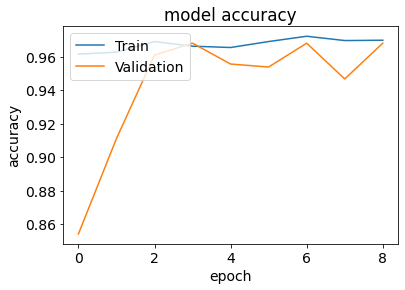

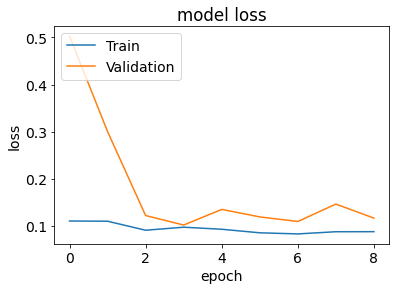

In [65]:
import matplotlib.pyplot as plt

# summarize history for accuracy
history=model2.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Models Predections

**Model1**

In [69]:
test_predictions = model1.predict(X_test_scaled)
preds1 = np.argmax(test_predictions, axis=1)
actual_label1 = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       310
           1       0.91      0.86      0.88       326
           2       0.96      0.99      0.97       419
           3       0.91      0.98      0.95       350

    accuracy                           0.94      1405
   macro avg       0.94      0.93      0.93      1405
weighted avg       0.94      0.94      0.94      1405



**Model2**

In [70]:
test_predictions = model5.predict(X_test_scaled)
preds2 = np.argmax(test_predictions, axis=1)
actual_label2 = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       310
           1       0.91      0.86      0.88       326
           2       0.96      0.99      0.97       419
           3       0.91      0.98      0.95       350

    accuracy                           0.94      1405
   macro avg       0.94      0.93      0.93      1405
weighted avg       0.94      0.94      0.94      1405



# Confusion Matrix

**First Model**

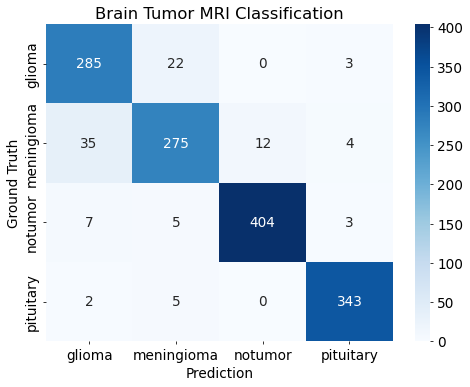

In [71]:
cnf = confusion_matrix(actual_label1, preds1)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

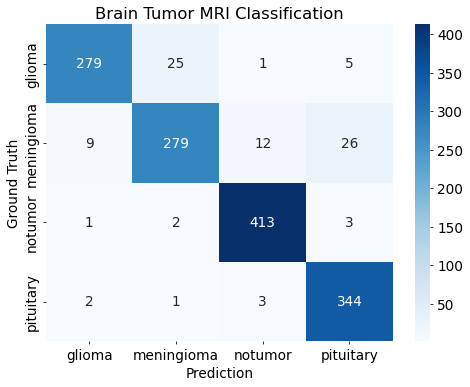

In [72]:
cnf = confusion_matrix(actual_label2, preds2)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)